In [2]:
import os
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Adjust these variables as needed:
base_dir = "target/criterion"
experiment = "DPrm vs. Prm, 4 threads"  # Replace with your experiment folder name.
variants = [
    "Full Prm Compute",
    "DPrm Obstacle Insertion",
]  # Replace with the names of your variants.

ns = ["10000", "20000", "40000", "80000", "160000"]
# Dictionary to hold data for each variant.
# We'll map each variant to a dictionary of { n_value: median_point_estimate }.
data = {variant: {} for variant in variants}


label = dict()
label["Full Prm Compute"] = "Full PRM* Execution"
label["DPrm Obstacle Insertion"] = "DPRM Obstacle Insertion"
marker = dict()
marker["Full Prm Compute"] = "x"
marker["DPrm Obstacle Insertion"] = "o"
linestyle = dict()
linestyle["Full Prm Compute"] = "--"
linestyle["DPrm Obstacle Insertion"] = "-"
color = dict()
color["Full Prm Compute"] = "gray"
color["DPrm Obstacle Insertion"] = "black"

for variant in variants:
    # Build a glob pattern that matches all n values for this variant.
    # The pattern corresponds to: base_dir/experiment/variant/*/new/estimates.json
    pattern = os.path.join(base_dir, experiment, variant, "*", "new", "estimates.json")
    for estimates_file in glob.glob(pattern):
        # Extract the [n] directory name.
        # The file path is: .../<experiment>/<variant>/<n>/new/estimates.json
        # We go up two directories from estimates_file: first up to "new", then to "<n>"
        n_str = os.path.basename(os.path.dirname(os.path.dirname(estimates_file)))
        try:
            # Convert n to a numeric value (e.g., int or float)
            n_value = float(n_str)
        except ValueError:
            # If the directory name is not a number, skip this file.
            print(f"Skipping non-numeric directory: {n_str}")
            continue
        if n_value < 10000:
            continue
        # Load the estimates.json file.
        with open(estimates_file, "r") as f:
            estimates = json.load(f)

        # Extract the mean point estimate.
        # (You can also extract other statistics, e.g., the confidence interval,
        #  if you’d like to include error bars.)
        mean_point = estimates["mean"]["point_estimate"]
        lb = estimates["mean"]["confidence_interval"]["lower_bound"]
        ub = estimates["mean"]["confidence_interval"]["upper_bound"]

        # Save the data point.
        data[variant][n_value] = (mean_point, lb, ub)

In [3]:
dfs = {}
for variant in variants:
    # Build a glob pattern that matches all n values for this variant.
    # The pattern corresponds to: base_dir/experiment/variant/*/new/estimates.json
    pattern = os.path.join(base_dir, experiment, variant, "*", "new", "sample.json")
    rows = []
    print(pattern)
    for samples_file in glob.glob(pattern):
        n_str = os.path.basename(os.path.dirname(os.path.dirname(samples_file)))
        try:
            # Convert n to a numeric value (e.g., int or float)
            n_value = float(n_str)
        except ValueError:
            # If the directory name is not a number, skip this file.
            print(f"Skipping non-numeric directory: {n_str}")
            continue
        if n_value < 10000:
            continue
        with open(samples_file, "r") as f:
            samples = json.load(f).get("times")
            if samples:
                row = samples + [n_value]
                rows.append(row)

    df = pd.DataFrame(rows)
    df.columns = [f"Sample_{i+1}" for i in range(df.shape[1]-1)] + ['n_value']  # Rename columns (samples + n_value)
    dfs[variant] = df



target/criterion/DPrm vs. Prm, 4 threads/Full Prm Compute/*/new/sample.json
target/criterion/DPrm vs. Prm, 4 threads/DPrm Obstacle Insertion/*/new/sample.json


/var/folders/tz/fvx5t98176g0bbx35x9zpjdr0000gn/T/ipykernel_68334/3372763667.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/var/folders/tz/fvx5t98176g0bbx35x9zpjdr0000gn/T/ipykernel_68334/3372763667.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(


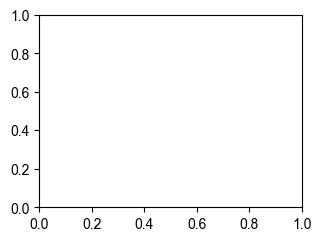

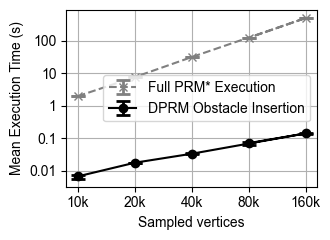

In [4]:
plt.rcParams.update({"font.size": 10, "font.family": "Arial"})
fig = plt.figure(figsize=(3.39, 2.5))
ax = fig.add_subplot(111)
fig, ax = plt.subplots(figsize=(3.4, 2.5))
multiplier = 1e-9

# Loop through each variant and plot
for variant, df in dfs.items():
    # Calculate the mean of each row (samples) for the y-values
    mean_series = df.iloc[:, :-1].mean(axis=1)  # Exclude the last column (n_value)

    # Calculate confidence intervals as yerr (error bars)
    yerr = np.abs(df.iloc[:, :-1].quantile([0.25, 0.75], axis=1) - mean_series)

    # Plot with error bars
    ax.errorbar(
        df["n_value"],
        mean_series * multiplier,
        yerr=yerr * multiplier,
        fmt="o",
        capsize=5,
        capthick=2,
        elinewidth=2,
        label=label[variant],
        color=color[variant],
        marker=marker[variant],
        linestyle=linestyle[variant],
    )


ax.set_xlabel("Sampled vertices")
ax.set_ylabel("Mean Execution Time (s)")
ax.set_title("")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_yticks([0.01, 0.1, 1, 10, 100])
ax.set_yticklabels(["0.01", "0.1", "1", "10", "100"])
ax.set_xticks([10000, 20000, 40000, 80000, 160000])
ax.set_xticklabels(["10k", "20k", "40k", "80k", "160k"])
ax.minorticks_off()
ax.legend()
ax.grid(True)
fig.tight_layout()
fig.savefig("dprm_vs_prm_v2.pdf")